In [2]:
import numpy as np

In [3]:
import pickle

In [4]:
from dftpy.optimize import Dynamics


class Runner(Dynamics):

    def __init__(self, rho0, totalfunctional, k, direction, interval, max_steps):
        super(Runner, self).__init__()
        self.max_steps = max_steps
        self.totalfunctional = totalfunctional
        self.rho0 = rho0
        self.rho = rho0
        self.psi = initial_kick(k, direction, np.sqrt(self.rho0))
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho0, current=self.j, calcType=['V']).potential
        hamiltonian = Hamiltonian(v=potential)
        self.prop = Propagator(hamiltonian, interval, name='crank-nicholson')
        self.dipole = []
        self.attach(self.calc_dipole) # this attaches the calc_dipole function to the observers list which runs after each time step.

    def step(self):
        self.psi, info = self.prop(self.psi)
        self.rho = calc_rho(self.psi)
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho, current=self.j, calcType=['V']).potential
        self.prop.hamiltonian.v = potential

    def calc_dipole(self):
        delta_rho = self.rho - self.rho0
        delta_mu = (delta_rho * delta_rho.grid.r).integral()
        self.dipole.append(delta_mu)

In [96]:
runner_tfvw    = np.load('quadrupole/quadrupole_jp_tfvw.npy')
runner_lkt     = np.load('quadrupole/quadrupole_jp_lkt.npy')
runner_mgp     = np.load('quadrupole/quadrupole_jp_mgp.npy', allow_pickle=True)
runner_lmgp     = np.load('quadrupole/quadrupole_jp_lmgp.npy', allow_pickle=True)

In [97]:
time_tfvw = runner_tfvw[:,0]
delta_mu_tfvw_xx = runner_tfvw[:,1]
delta_mu_tfvw_xy = runner_tfvw[:,2]
delta_mu_tfvw_xz = runner_tfvw[:,3]

delta_mu_tfvw_yx = runner_tfvw[:,4]
delta_mu_tfvw_yy = runner_tfvw[:,5]
delta_mu_tfvw_yz = runner_tfvw[:,6]

delta_mu_tfvw_zx = runner_tfvw[:,7]
delta_mu_tfvw_zy = runner_tfvw[:,8]
delta_mu_tfvw_zz = runner_tfvw[:,9]

delta_mu_tfvw_t = runner_tfvw[:,1] + runner_tfvw[:,5] + runner_tfvw[:,9]

time_lkt = runner_lkt[:,0]
delta_mu_lkt_xx = runner_lkt[:,1]
delta_mu_lkt_xy = runner_lkt[:,2]
delta_mu_lkt_xz = runner_lkt[:,3]

delta_mu_lkt_yx = runner_lkt[:,4]
delta_mu_lkt_yy = runner_lkt[:,5]
delta_mu_lkt_yz = runner_lkt[:,6]

delta_mu_lkt_zx = runner_lkt[:,7]
delta_mu_lkt_zy = runner_lkt[:,8]
delta_mu_lkt_zz = runner_lkt[:,9]

time_lmgp = runner_lmgp[:,0]
delta_mu_lmgp_xx = runner_lmgp[:,1]
delta_mu_lmgp_xy = runner_lmgp[:,2]
delta_mu_lmgp_xz = runner_lmgp[:,3]

delta_mu_lmgp_yx = runner_lmgp[:,4]
delta_mu_lmgp_yy = runner_lmgp[:,5]
delta_mu_lmgp_yz = runner_lmgp[:,6]

delta_mu_lmgp_zx = runner_lmgp[:,7]
delta_mu_lmgp_zy = runner_lmgp[:,8]
delta_mu_lmgp_zz = runner_lmgp[:,9]

time_mgp = runner_mgp[:,0]
delta_mu_mgp_xx = runner_mgp[:,1]
delta_mu_mgp_xy = runner_mgp[:,2]
delta_mu_mgp_xz = runner_mgp[:,3]

delta_mu_mgp_yx = runner_mgp[:,4]
delta_mu_mgp_yy = runner_mgp[:,5]
delta_mu_mgp_yz = runner_mgp[:,6]

delta_mu_mgp_zx = runner_mgp[:,7]
delta_mu_mgp_zy = runner_mgp[:,8]
delta_mu_mgp_zz = runner_mgp[:,9]

In [109]:
max_steps_tfvw = 24000
max_steps_lkt = 24000
max_steps_lmgp = 9600
max_steps_mgp = 24000
interval = 0.041341374575751
k = 1.0e-3

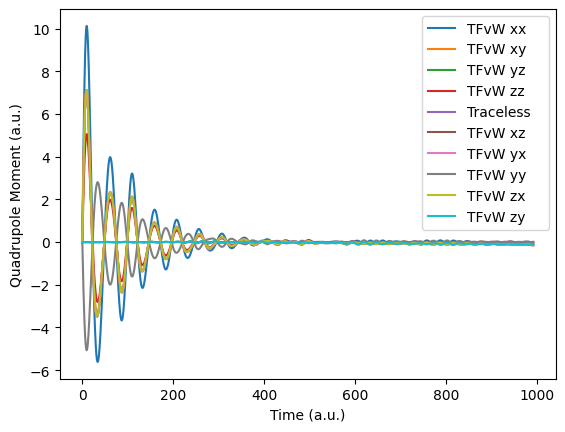

In [135]:
import matplotlib.pyplot as plt
# xy=xz, yz +=0
plt.plot(time_tfvw, delta_mu_tfvw_xx   , label='TFvW xx  ')
plt.plot(time_tfvw, delta_mu_tfvw_xy   , label='TFvW xy  ')
plt.plot(time_tfvw, delta_mu_tfvw_yz   , label='TFvW yz  ')
plt.plot(time_tfvw, -delta_mu_tfvw_zz   , label='TFvW zz  ')
plt.plot(time_tfvw, delta_mu_tfvw_t   , label='Traceless   ')

plt.plot(time_tfvw, delta_mu_tfvw_xz   , label='TFvW xz  ')
plt.plot(time_tfvw, delta_mu_tfvw_yx   , label='TFvW yx  ')
plt.plot(time_tfvw, delta_mu_tfvw_yy   , label='TFvW yy  ')
plt.plot(time_tfvw, delta_mu_tfvw_zx   , label='TFvW zx  ')
plt.plot(time_tfvw, delta_mu_tfvw_zy   , label='TFvW zy  ')


plt.xlabel('Time (a.u.)')
plt.ylabel('Quadrupole Moment (a.u.)')
plt.legend()
# plt.ylim(-0.25*1e10,0.25*1e10)
plt.show()


In [75]:
def calc_spectra_mu(delta_mu, interval, max_steps, freq, k, sm, use_ft):
    if freq is None and not use_ft:
        freq = np.fft.rfftfreq(max_steps, interval)
    t = interval * np.arange(max_steps)
    delta_mu1 = delta_mu * np.exp(-sm*t)
    if not use_ft:
        delta_mu1_fft = np.fft.rfft(delta_mu1)
    else:
        delta_mu1_fft = ft(delta_mu1, t, freq*2.0*np.pi)
    spectra = -np.imag(delta_mu1_fft)*freq*2.0*np.pi*t[1]
    spectra = spectra * 2 / np.pi / k

    return freq, spectra

In [76]:
def plot(freq, spectra, upperlimit, **kwargs):
    maxdata = int(upperlimit/(freq[1]*2.0*np.pi*27.2114))
    plt.plot(freq[:maxdata]*2.0*np.pi*27.2114, spectra[:maxdata], **kwargs)

In [77]:
def ft(f_t, t, omega):
    f_omega = np.zeros(np.shape(omega), dtype = np.complex128)
    for i in range(np.size(omega)):
        f_omega[i]=np.sum(f_t*np.exp(-1.0j*omega[i]*t))

    return f_omega

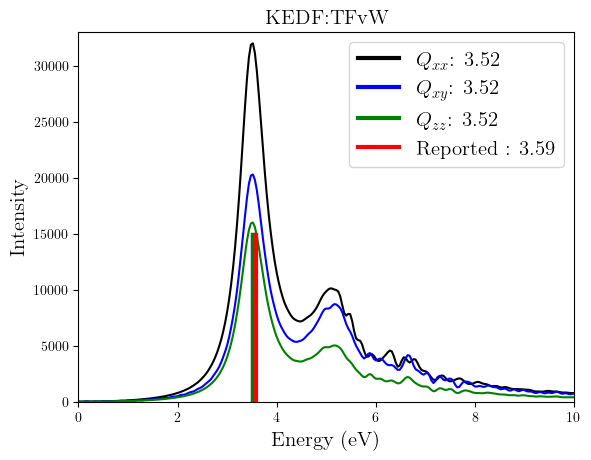

In [157]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', stretch='condensed')
freq = np.linspace(0, 10 / (2.0*np.pi*27.2114), 251)

freq_tfvw_xx   , spectra_tfvw_xx    = calc_spectra_mu(delta_mu_tfvw_xx, interval, max_steps_tfvw, freq=freq, k=k, sm= 0.001, use_ft=True)
freq_tfvw_xy   , spectra_tfvw_xy    = calc_spectra_mu(delta_mu_tfvw_xy, interval, max_steps_tfvw, freq=freq, k=k, sm= 0.001, use_ft=True)
freq_tfvw_zz   , spectra_tfvw_zz    = calc_spectra_mu(-delta_mu_tfvw_zz, interval, max_steps_tfvw, freq=freq, k=k, sm= 0.001, use_ft=True)

plot(freq_tfvw_xx   , spectra_tfvw_xx   , 20, color = 'k')#, label='oepp   ')
plot(freq_tfvw_xy   , spectra_tfvw_xy   , 20, color = 'b')#, label='oepp   ')
plot(freq_tfvw_zz   , spectra_tfvw_zz   , 20, color = 'g')#, label='oepp   ')

max_y_tfvw_xx    = max(spectra_tfvw_xx   ) 
max_y_tfvw_xy    = max(spectra_tfvw_xy   ) 
max_y_tfvw_zz    = max(spectra_tfvw_zz   ) 

max_x_tfvw_xx    = freq_tfvw_xx [list(spectra_tfvw_xx).index(max_y_tfvw_xx)]
max_x_tfvw_xy    = freq_tfvw_xy [list(spectra_tfvw_xy).index(max_y_tfvw_xy)]
max_x_tfvw_zz    = freq_tfvw_zz [list(spectra_tfvw_zz).index(max_y_tfvw_zz)]

plt.axvline(x = max_x_tfvw_xx  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'k', label = r'$Q_{xx}$: '+str(round(max_x_tfvw_xx   *(2.0*np.pi*27.2114), 2)))
plt.axvline(x = max_x_tfvw_xy  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'b', label = r'$Q_{xy}$: '+str(round(max_x_tfvw_xy   *(2.0*np.pi*27.2114), 2)))
plt.axvline(x = max_x_tfvw_zz  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'g', label = r'$Q_{zz}$: '+str(round(max_x_tfvw_zz   *(2.0*np.pi*27.2114), 2)))
plt.axvline(x = 3.59, ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'red', label = 'Reported   : '+str(3.59))

plt.xlabel('Energy (eV)',fontsize="15")
plt.ylabel('Intensity',fontsize="15")
plt.title('KEDF:TFvW',fontsize="15")
plt.xlim(0, 10)
plt.ylim(0, 33000)
plt.legend(fontsize="15")
## x:frequency
## y:optical spectra
plt.savefig('tfvw.png', bbox_inches='tight', dpi=200)

In [103]:
freq = np.linspace(0, 10 / (2.0*np.pi*27.2114), 251)

freq_lmgp_xx   , spectra_lmgp_xx    = calc_spectra_mu(delta_mu_lmgp_xx, interval, max_steps_lmgp, freq=freq, k=k, sm= 0.001, use_ft=True)
freq_lmgp_xy   , spectra_lmgp_xy    = calc_spectra_mu(delta_mu_lmgp_xy, interval, max_steps_lmgp, freq=freq, k=k, sm= 0.001, use_ft=True)
freq_lmgp_zz   , spectra_lmgp_zz    = calc_spectra_mu(-delta_mu_lmgp_zz, interval, max_steps_lmgp, freq=freq, k=k, sm= 0.001, use_ft=True)

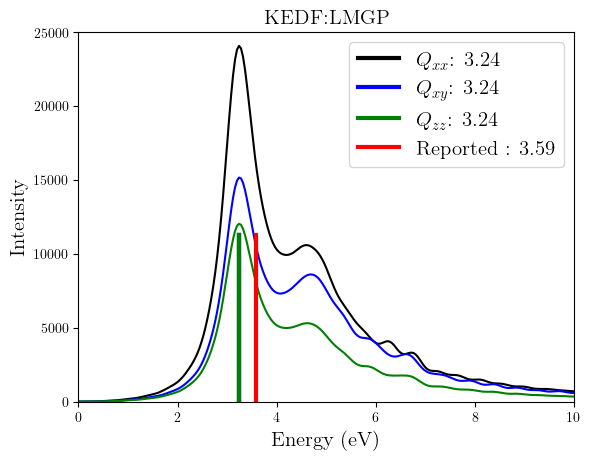

In [152]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', stretch='condensed')
plot(freq_lmgp_xx   , spectra_lmgp_xx   , 20, color = 'k')#, label='oepp   ')
plot(freq_lmgp_xy   , spectra_lmgp_xy   , 20, color = 'b')#, label='oepp   ')
plot(freq_lmgp_zz   , spectra_lmgp_zz   , 20, color = 'g')#, label='oepp   ')

max_y_lmgp_xx    = max(spectra_lmgp_xx) 
max_y_lmgp_xy    = max(spectra_lmgp_xy) 
max_y_lmgp_zz    = max(spectra_lmgp_zz) 

max_x_lmgp_xx    = freq_lmgp_xx [list(spectra_lmgp_xx).index(max_y_lmgp_xx)]
max_x_lmgp_xy    = freq_lmgp_xy [list(spectra_lmgp_xy).index(max_y_lmgp_xy)]
max_x_lmgp_zz    = freq_lmgp_zz [list(spectra_lmgp_zz).index(max_y_lmgp_zz)]

plt.axvline(x = max_x_lmgp_xx  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'k', label = r'$Q_{xx}$: '+str(round(max_x_lmgp_xx   *(2.0*np.pi*27.2114), 2)))
plt.axvline(x = max_x_lmgp_xy  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'b', label = r'$Q_{xy}$: '+str(round(max_x_lmgp_xy   *(2.0*np.pi*27.2114), 2)))
plt.axvline(x = max_x_lmgp_zz  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'g', label = r'$Q_{zz}$: '+str(round(max_x_lmgp_zz   *(2.0*np.pi*27.2114), 2)))

plt.axvline(x = 3.59, ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'red', label = 'Reported   : '+str(3.59))

plt.xlabel('Energy (eV)',fontsize="15")
plt.ylabel('Intensity', fontsize="15")
plt.title('KEDF:LMGP',fontsize="15")
plt.xlim(0, 10)
plt.ylim(0, 25000)
plt.legend(fontsize="15")
## x:frequency
## y:optical spectra
plt.savefig('lmgp.png' , bbox_inches='tight', dpi=200)

In [106]:
freq = np.linspace(0, 10 / (2.0*np.pi*27.2114), 251)

freq_mgp_xx   , spectra_mgp_xx    = calc_spectra_mu(delta_mu_mgp_xx, interval, max_steps_mgp, freq=freq, k=k, sm= 0.005, use_ft=True)
freq_mgp_xy   , spectra_mgp_xy    = calc_spectra_mu(delta_mu_mgp_xy, interval, max_steps_mgp, freq=freq, k=k, sm= 0.005, use_ft=True)
freq_mgp_zz   , spectra_mgp_zz    = calc_spectra_mu(-delta_mu_mgp_zz, interval, max_steps_mgp, freq=freq, k=k, sm= 0.005, use_ft=True)

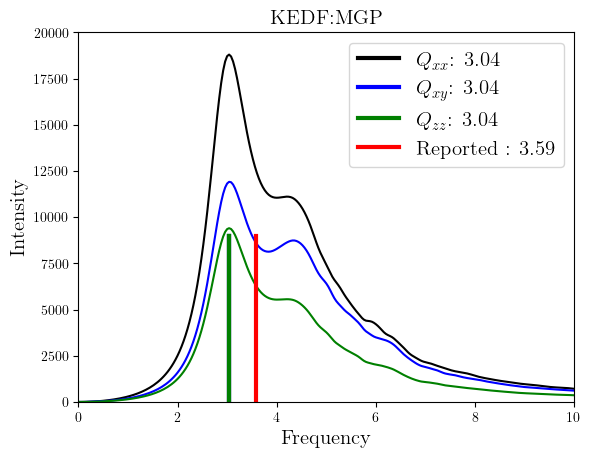

In [151]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', stretch='condensed')
plot(freq_mgp_xx   , spectra_mgp_xx   , 20, color = 'k')#, label='oepp   ')
plot(freq_mgp_xy   , spectra_mgp_xy   , 20, color = 'b')#, label='oepp   ')
plot(freq_mgp_zz   , spectra_mgp_zz   , 20, color = 'g')#, label='oepp   ')

max_y_mgp_xx    = max(spectra_mgp_xx) 
max_y_mgp_xy    = max(spectra_mgp_xy) 
max_y_mgp_zz    = max(spectra_mgp_zz) 

max_x_mgp_xx    = freq_mgp_xx [list(spectra_mgp_xx).index(max_y_mgp_xx)]
max_x_mgp_xy    = freq_mgp_xy [list(spectra_mgp_xy).index(max_y_mgp_xy)]
max_x_mgp_zz    = freq_mgp_zz [list(spectra_mgp_zz).index(max_y_mgp_zz)]

plt.axvline(x = max_x_mgp_xx  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'k', label = r'$Q_{xx}$: '+str(round(max_x_mgp_xx   *(2.0*np.pi*27.2114), 2)))
plt.axvline(x = max_x_mgp_xy  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'b', label = r'$Q_{xy}$: '+str(round(max_x_mgp_xy   *(2.0*np.pi*27.2114), 2)))
plt.axvline(x = max_x_mgp_zz  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'g', label = r'$Q_{zz}$: '+str(round(max_x_mgp_zz   *(2.0*np.pi*27.2114), 2)))

# plt.axvline(x = 2*max_x_mgp_xx  *(2.0*np.pi*27.2114), ymax=0.5, ymin=0, linestyle='-', linewidth=3, color = 'k')
# plt.axvline(x = 2*max_x_mgp_xy  *(2.0*np.pi*27.2114), ymax=0.5, ymin=0, linestyle='-', linewidth=3, color = 'b')
# plt.axvline(x = 2*max_x_mgp_zz  *(2.0*np.pi*27.2114), ymax=0.5, ymin=0, linestyle='-', linewidth=3, color = 'g')

plt.axvline(x = 3.59, ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'red', label = 'Reported   : '+str(3.59))

plt.xlabel('Frequency',fontsize="15")
plt.ylabel('Intensity',fontsize="15")
plt.title('KEDF:MGP',fontsize="15")
plt.xlim(0, 10)
plt.ylim(0, 20000)
plt.legend(fontsize="15")
## x:frequency
## y:optical spectra

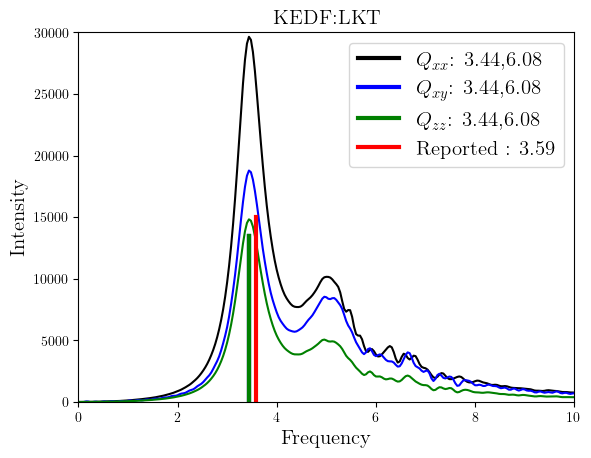

In [150]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', stretch='condensed')
freq_lkt_xx, spectra_lkt_xx= calc_spectra_mu(delta_mu_lkt_xx   , interval, max_steps_lkt,  freq=freq, k=k, sm= 0.001, use_ft=True)
freq_lkt_zz, spectra_lkt_zz= calc_spectra_mu(-delta_mu_lkt_zz   , interval, max_steps_lkt,  freq=freq, k=k, sm= 0.001, use_ft=True)
freq_lkt_xy, spectra_lkt_xy= calc_spectra_mu(delta_mu_lkt_xy   , interval, max_steps_lkt,  freq=freq, k=k, sm= 0.001, use_ft=True)
freq_lkt_zy, spectra_lkt_zy= calc_spectra_mu(delta_mu_lkt_zy   , interval, max_steps_lkt,  freq=freq, k=k, sm= 0.001, use_ft=True)
freq_lkt_yy, spectra_lkt_yy= calc_spectra_mu(-delta_mu_lkt_yy   , interval, max_steps_lkt,  freq=freq, k=k, sm= 0.001, use_ft=True)

plot(freq_lkt_xx , spectra_lkt_xx , 20, color = 'k')#, label='oepp   ')
plot(freq_lkt_xy , spectra_lkt_xy , 20, color = 'b')#, label='oepp   ')
plot(freq_lkt_zz , spectra_lkt_zz , 20, color = 'g')#, label='oepp   ')
# plot(freq_lkt_zy , spectra_lkt_zy , 20, color = 'pink')#, label='oepp   ')
# plot(freq_lkt_yy , spectra_lkt_yy , 20, color = 'orange')#, label='oepp   ')

max_y_lkt_xx    = max(spectra_lkt_xx) 
max_y_lkt_xy    = max(spectra_lkt_xy) 
max_y_lkt_zz    = max(spectra_lkt_zz) 

max_x_lkt_xx    = freq_lkt_xx [list(spectra_lkt_xx).index(max_y_lkt_xx)]
max_x_lkt_xy    = freq_lkt_xy [list(spectra_lkt_xy).index(max_y_lkt_xy)]
max_x_lkt_zz    = freq_lkt_zz [list(spectra_lkt_zz).index(max_y_lkt_zz)]

plt.axvline(x = max_x_lkt_xx  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'k', label = r'$Q_{xx}$: '+str(round(max_x_lkt_xx   *(2.0*np.pi*27.2114), 2))+','+str(round(2*max_x_mgp_xx   *(2.0*np.pi*27.2114), 2)))
plt.axvline(x = max_x_lkt_xy  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'b', label = r'$Q_{xy}$: '+str(round(max_x_lkt_xy   *(2.0*np.pi*27.2114), 2))+','+str(round(2*max_x_mgp_xy   *(2.0*np.pi*27.2114), 2)))
plt.axvline(x = max_x_lkt_zz  *(2.0*np.pi*27.2114), ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'g', label = r'$Q_{zz}$: '+str(round(max_x_lkt_zz   *(2.0*np.pi*27.2114), 2))+','+str(round(2*max_x_mgp_zz   *(2.0*np.pi*27.2114), 2)))

# plt.axvline(x = 2*max_x_mgp_xx  *(2.0*np.pi*27.2114), ymax=0.5, ymin=0, linestyle='-', linewidth=3, color = 'k')
# plt.axvline(x = 2*max_x_mgp_xy  *(2.0*np.pi*27.2114), ymax=0.5, ymin=0, linestyle='-', linewidth=3, color = 'b')
# plt.axvline(x = 2*max_x_mgp_zz  *(2.0*np.pi*27.2114), ymax=0.5, ymin=0, linestyle='-', linewidth=3, color = 'g')

plt.axvline(x = 3.59, ymax=0.45, ymin=0, linestyle='-', linewidth=3, color = 'red', label = 'Reported   : '+str(3.59))

plt.xlabel('Frequency',fontsize="15")
plt.ylabel('Intensity',fontsize="15")
plt.title('KEDF:LKT',fontsize="15")
plt.xlim(0, 10)
plt.ylim(0, 30000)
plt.legend(fontsize="15")
## x:frequency
## y:optical spectra